In [46]:
from chembl_webresource_client.new_client import new_client
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors

In [ ]:
def fetch_chembl_activity_to_polars(target_id="CHEMBL203", activity_type="IC50"):
    activity = new_client.activity
    query = activity.filter(target_chembl_id=target_id).filter(standard_type=activity_type)
    
    print(f"Pobieranie danych dla celu: {target_id}...")
    data = list(query)

    if data:
        df = pl.DataFrame(data, infer_schema_length=None)
        
        # Konwersja standard_value na float (jeśli istnieje)
        if "standard_value" in df.columns:
             df = df.with_columns(
                pl.col("standard_value").cast(pl.Float64, strict=False)
            )
        
        return df
    else:
        print("Nie znaleziono danych.")
        return pl.DataFrame()

# Uruchomienie
df_activity = fetch_chembl_activity_to_polars()


Pobieranie danych dla celu: CHEMBL203...


In [27]:
# 1. Ustawienie konfiguracji (globalnie dla sesji)
pl.Config.set_tbl_cols(100)       # Pokazuj do 100 kolumn
pl.Config.set_tbl_rows(20)        # Pokazuj do 20 wierszy
pl.Config.set_tbl_width_chars(2000) # Zwiększ szerokość wyświetlania w konsoli

# 2. Wyświetlenie DataFrame
print(f"Pobrano {len(df_activity)} wierszy.")
print(df_activity.head())

Pobrano 25758 wierszy.
shape: (5, 46)
┌─────────────┬──────────────────┬─────────────┬─────────────────────┬─────────────────┬─────────────────────────────────┬────────────┬─────────────────────────┬────────────────────────┬──────────────┬─────────────┬───────────────────────┬─────────────────────────────────┬───────────────────────┬───────────────────────────┬────────────────────┬──────────────────────┬───────────────┬────────────────────────────────┬────────────────────┬────────────────────┬───────────────────────────┬───────────────┬─────────────────────┬─────────────────────────────────┬───────────┬──────────┬────────┬───────────────┬───────────────────┬─────────────────────┬───────────────┬────────────────┬──────────────────────┬────────────────┬──────────────────┬─────────────────┬─────────────────────────────────┬───────────────┬────────────┬──────┬──────┬───────┬────────────┬─────────────┬───────┐
│ action_type ┆ activity_comment ┆ activity_id ┆ activity_properties ┆ assay_chem

In [32]:
# 1. Konwersja typów i wstępne czyszczenie
df_clean = (
    df_activity.unique(subset=["record_id"], keep="first")
    .with_columns(
        pl.col("pchembl_value").cast(pl.Float64, strict=False)
    )
    .filter(
        (pl.col("standard_value").is_not_null()) &
        (pl.col("canonical_smiles").is_not_null()) &
        (pl.col("standard_relation") == "=") &
        (pl.col("standard_units") == "nM")
    )
)

print(f"Liczba wierszy przed czyszczeniem: {len(df_activity)}")
print(f"Liczba wierszy po czyszczeniu: {len(df_clean)}")

df_unique = (
    df_clean
    .group_by("molecule_chembl_id")
    .agg([
        pl.col("pchembl_value").mean().alias("mean_pchembl"),
        pl.col("standard_value").mean().alias("mean_standard_value"),
        pl.col("canonical_smiles").first() # Bierzemy pierwszy SMILES
    ])
)

print(f"Liczba unikalnych cząsteczek: {len(df_unique)}")

Liczba wierszy przed czyszczeniem: 25758
Liczba wierszy po czyszczeniu: 12634
Liczba unikalnych cząsteczek: 10254


In [33]:
# 2. Sprawdzenie duplikatów (jedna cząsteczka mogła być badana wielokrotnie)
# Grupujemy po ID cząsteczki i liczymy średnią z pchembl_value i standard_value
df_unique = (
    df_clean
    .group_by("molecule_chembl_id")
    .agg([
        pl.col("pchembl_value").mean().alias("mean_pchembl"),
        pl.col("standard_value").mean().alias("mean_standard_value"),
        pl.col("canonical_smiles").first() # Bierzemy pierwszy SMILES
    ])
)

print(f"Liczba unikalnych cząsteczek: {len(df_unique)}")

Liczba unikalnych cząsteczek: 10254


Wykresy zostały wygenerowane.


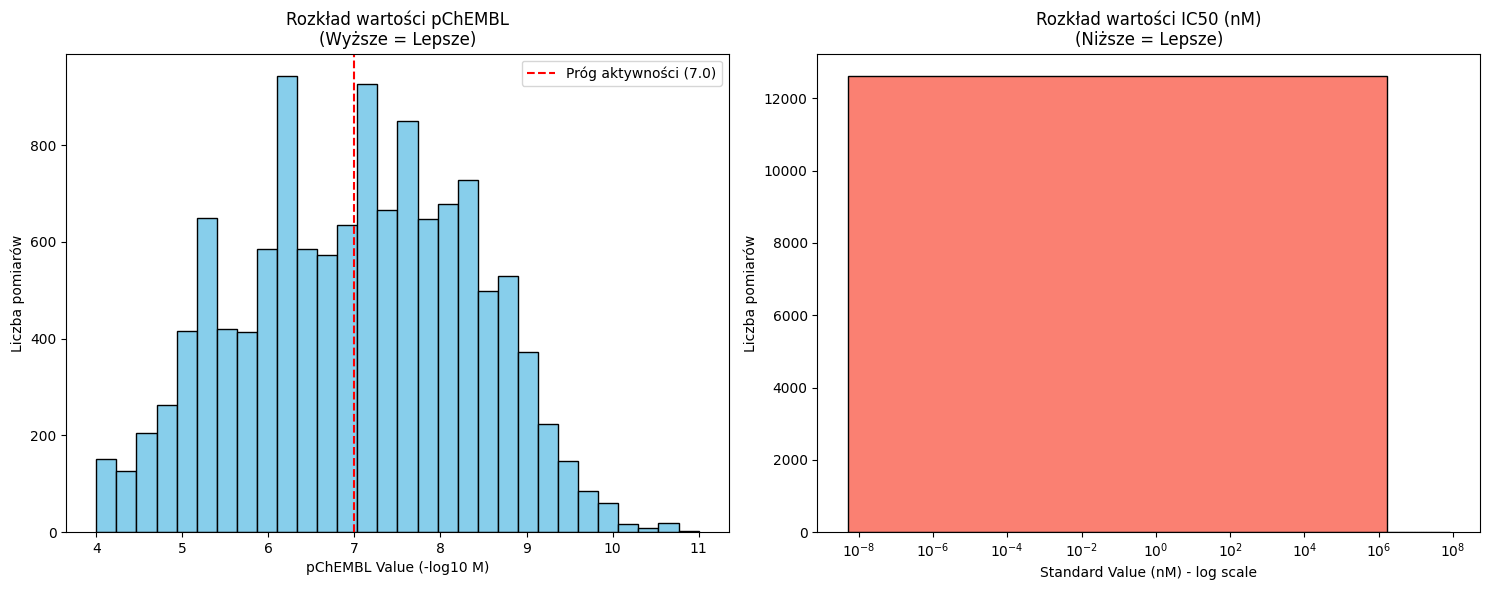

In [34]:
# Przygotowanie danych do wykresu (Polars -> Numpy/List)
pchembl_vals = df_clean["pchembl_value"].drop_nulls().to_list()
std_vals = df_clean["standard_value"].drop_nulls().to_list()

# Tworzenie wykresów
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Wykres 1: Rozkład pChEMBL (skala logarytmiczna aktywności)
# Wartości > 6-7 są zazwyczaj uważane za aktywne, > 9 za bardzo silne
ax[0].hist(pchembl_vals, bins=30, color='skyblue', edgecolor='black')
ax[0].set_title('Rozkład wartości pChEMBL\n(Wyższe = Lepsze)')
ax[0].set_xlabel('pChEMBL Value (-log10 M)')
ax[0].set_ylabel('Liczba pomiarów')
ax[0].axvline(x=7, color='red', linestyle='--', label='Próg aktywności (7.0)')
ax[0].legend()

# Wykres 2: Rozkład Standard Value (IC50 w nM) - Skala logarytmiczna na osi X
# Tutaj niższe wartości są lepsze (potrzeba mniej leku, by zachamować cel)
ax[1].hist(std_vals, bins=50, color='salmon', edgecolor='black')
ax[1].set_xscale('log') # Kluczowe dla stężeń!
ax[1].set_title('Rozkład wartości IC50 (nM)\n(Niższe = Lepsze)')
ax[1].set_xlabel('Standard Value (nM) - log scale')
ax[1].set_ylabel('Liczba pomiarów')

plt.tight_layout()
print("Wykresy zostały wygenerowane.")
plt.show() # Odkomentuj jeśli używasz Jupyter Notebook

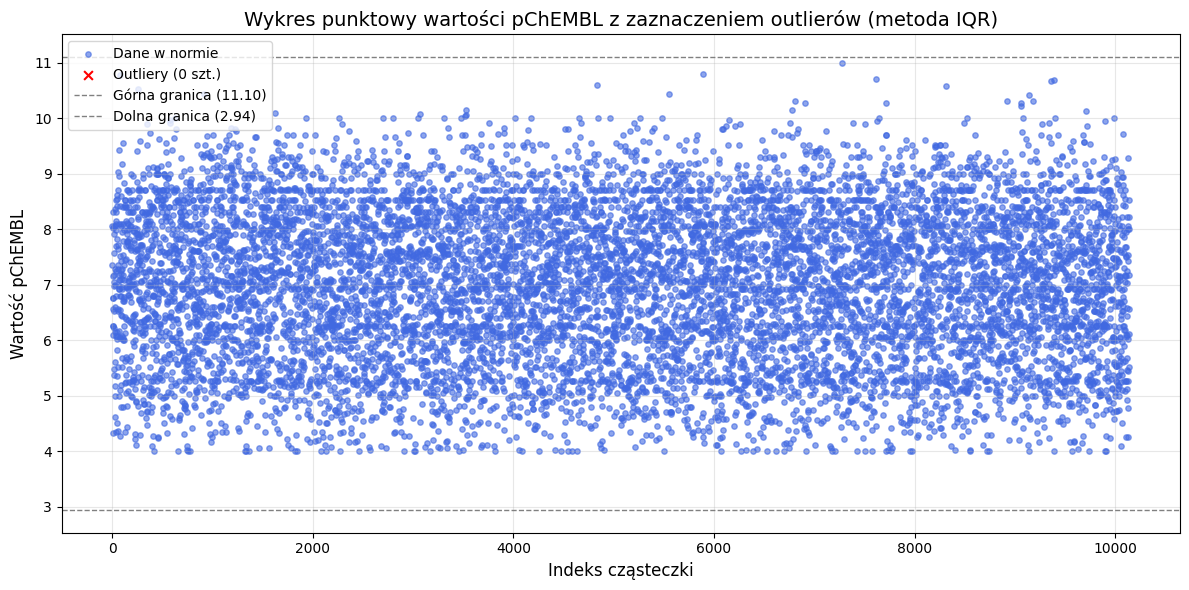

In [ ]:
# 1. Przygotowanie danych (konwersja kolumny Polars na listę/numpy)
values = df_unique["mean_pchembl"].drop_nulls().to_numpy()
indices = np.arange(len(values))

# 2. Obliczenie statystyk do wykrywania outlierów (Metoda IQR)
q1 = np.percentile(values, 25)
q3 = np.percentile(values, 75)
iqr = q3 - q1

# Definicja granic (standardowo 1.5 * IQR)
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# 3. Wyznaczenie masek dla punktów normalnych i outlierów
outliers_mask = (values < lower_bound) | (values > upper_bound)
inliers_mask = ~outliers_mask

# 4. Rysowanie wykresu
plt.figure(figsize=(12, 6))

# Rysujemy punkty "w normie"
plt.scatter(indices[inliers_mask], values[inliers_mask], 
            c='royalblue', alpha=0.6, s=15, label='Dane w normie')

# Rysujemy outliery
plt.scatter(indices[outliers_mask], values[outliers_mask], 
            c='red', marker='x', s=40, label=f'Outliery ({outliers_mask.sum()} szt.)')

# Dodajemy linie odcięcia
plt.axhline(y=upper_bound, color='gray', linestyle='--', linewidth=1, label=f'Górna granica ({upper_bound:.2f})')
plt.axhline(y=lower_bound, color='gray', linestyle='--', linewidth=1, label=f'Dolna granica ({lower_bound:.2f})')

# Opisy
plt.title('Wykres punktowy wartości pChEMBL z zaznaczeniem outlierów (metoda IQR)', fontsize=14)
plt.xlabel('Indeks cząsteczki', fontsize=12)
plt.ylabel('Wartość pChEMBL', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Dane gotowe. Liczba punktów czasowych: 34


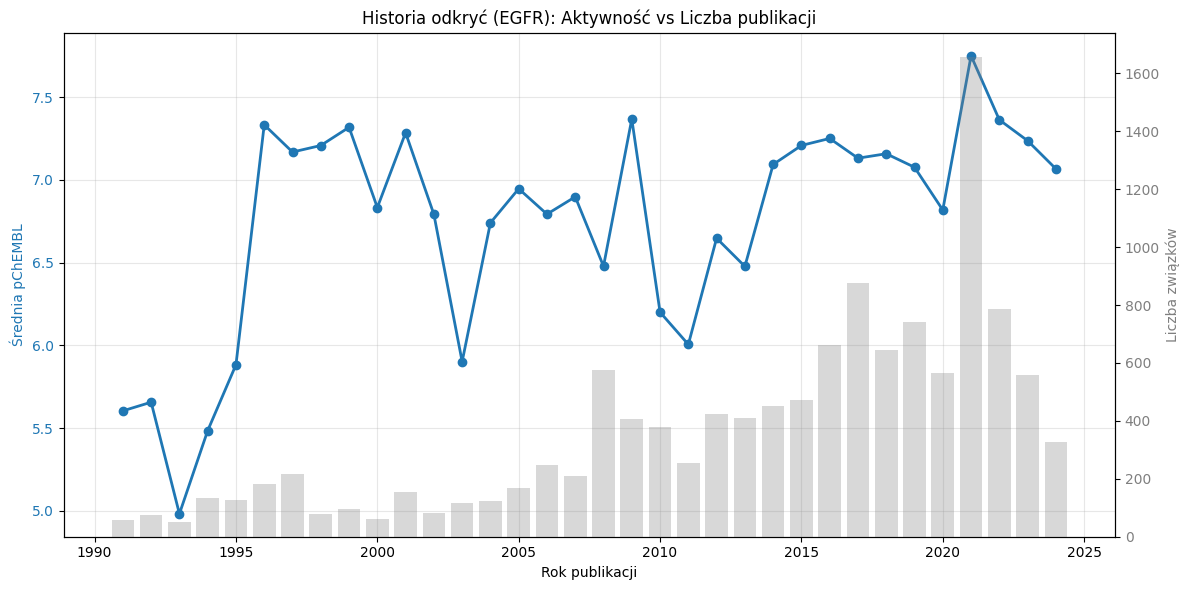

In [45]:
# 1. Agregacja z bezpiecznym rzutowaniem typów
df_temporal = (
    df_clean
    # Upewniamy się, że rok jest liczbą (jeśli był tekstem) i odrzucamy błędy
    .with_columns(
        pl.col("document_year").cast(pl.Int32, strict=False)
    )
    # Filtrujemy braki danych w roku ORAZ w pChEMBL
    .filter(
        pl.col("document_year").is_not_null() & 
        (pl.col("document_year") > 1990) &  # Opcjonalnie: odrzucamy błędne stare daty
        pl.col("pchembl_value").is_not_null()
    )
    .group_by("document_year")
    .agg([
        pl.col("pchembl_value").mean().alias("mean_pchembl"),
        pl.col("pchembl_value").max().alias("max_pchembl"),
        pl.col("molecule_chembl_id").count().alias("count")
    ])
    .sort("document_year")
)

# Sprawdzenie czy mamy dane do rysowania
if len(df_temporal) == 0:
    print("UWAGA: Brak danych do wyrysowania po agregacji!")
else:
    print(f"Dane gotowe. Liczba punktów czasowych: {len(df_temporal)}")
    
    # 2. Rysowanie wykresu
    years = df_temporal["document_year"].to_list()
    mean_pchembl = df_temporal["mean_pchembl"].to_list()
    counts = df_temporal["count"].to_list()

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Oś lewa: Średnia aktywność
    color = 'tab:blue'
    ax1.set_xlabel('Rok publikacji')
    ax1.set_ylabel('Średnia pChEMBL', color=color)
    ax1.plot(years, mean_pchembl, color=color, marker='o', linestyle='-', linewidth=2, label='Średnia pChEMBL')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, alpha=0.3)

    # Oś prawa: Liczba związków
    ax2 = ax1.twinx()
    color = 'tab:gray'
    ax2.set_ylabel('Liczba związków', color=color)
    ax2.bar(years, counts, color=color, alpha=0.3, label='Liczba związków')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title('Historia odkryć (EGFR): Aktywność vs Liczba publikacji')
    fig.tight_layout()  # Poprawia układ, żeby etykiety się nie ucinały
    plt.show()

In [47]:
# Funkcja pomocnicza do obliczania deskryptorów
def calculate_lipinski_props(df):
    data_props = []
    
    # Iterujemy po danych (ID i SMILES)
    # Używamy iter_rows dla prostoty, przy 10k cząsteczek to potrwa kilka sekund
    for row in df.select(["molecule_chembl_id", "canonical_smiles"]).iter_rows(named=True):
        smi = row["canonical_smiles"]
        mid = row["molecule_chembl_id"]
        
        if smi:
            try:
                mol = Chem.MolFromSmiles(smi)
                if mol:
                    data_props.append({
                        "molecule_chembl_id": mid,
                        "MW": Descriptors.MolWt(mol),
                        "LogP": Descriptors.MolLogP(mol),
                        "HBD": Descriptors.NumHDonors(mol),
                        "HBA": Descriptors.NumHAcceptors(mol)
                    })
            except:
                continue # Pomijamy błędy parsowania

    return pl.DataFrame(data_props)

print("Rozpoczynam obliczanie właściwości fizykochemicznych...")
df_props = calculate_lipinski_props(df_unique)

# Łączymy wyniki z naszą główną tabelą df_unique
df_analysis = df_unique.join(df_props, on="molecule_chembl_id", how="inner")

print(f"Gotowe! Obliczono właściwości dla {len(df_analysis)} cząsteczek.")
print(df_analysis.head(3))

Rozpoczynam obliczanie właściwości fizykochemicznych...
Gotowe! Obliczono właściwości dla 10254 cząsteczek.
shape: (3, 8)
┌────────────────────┬──────────────┬─────────────────────┬─────────────────────────────────┬─────────┬────────┬─────┬─────┐
│ molecule_chembl_id ┆ mean_pchembl ┆ mean_standard_value ┆ canonical_smiles                ┆ MW      ┆ LogP   ┆ HBD ┆ HBA │
│ ---                ┆ ---          ┆ ---                 ┆ ---                             ┆ ---     ┆ ---    ┆ --- ┆ --- │
│ str                ┆ f64          ┆ f64                 ┆ str                             ┆ f64     ┆ f64    ┆ i64 ┆ i64 │
╞════════════════════╪══════════════╪═════════════════════╪═════════════════════════════════╪═════════╪════════╪═════╪═════╡
│ CHEMBL4469866      ┆ 8.06         ┆ 8.7                 ┆ C=CC(=O)N(c1cccc(Cl)c1F)c1ncnc… ┆ 513.957 ┆ 4.4163 ┆ 0   ┆ 7   │
│ CHEMBL3671527      ┆ 7.35         ┆ 45.0                ┆ C=CC(=O)Nc1cc2c(Nc3ccc(Br)c(Cl… ┆ 579.858 ┆ 5.5294 ┆ 4   ┆ 6   │
│ C

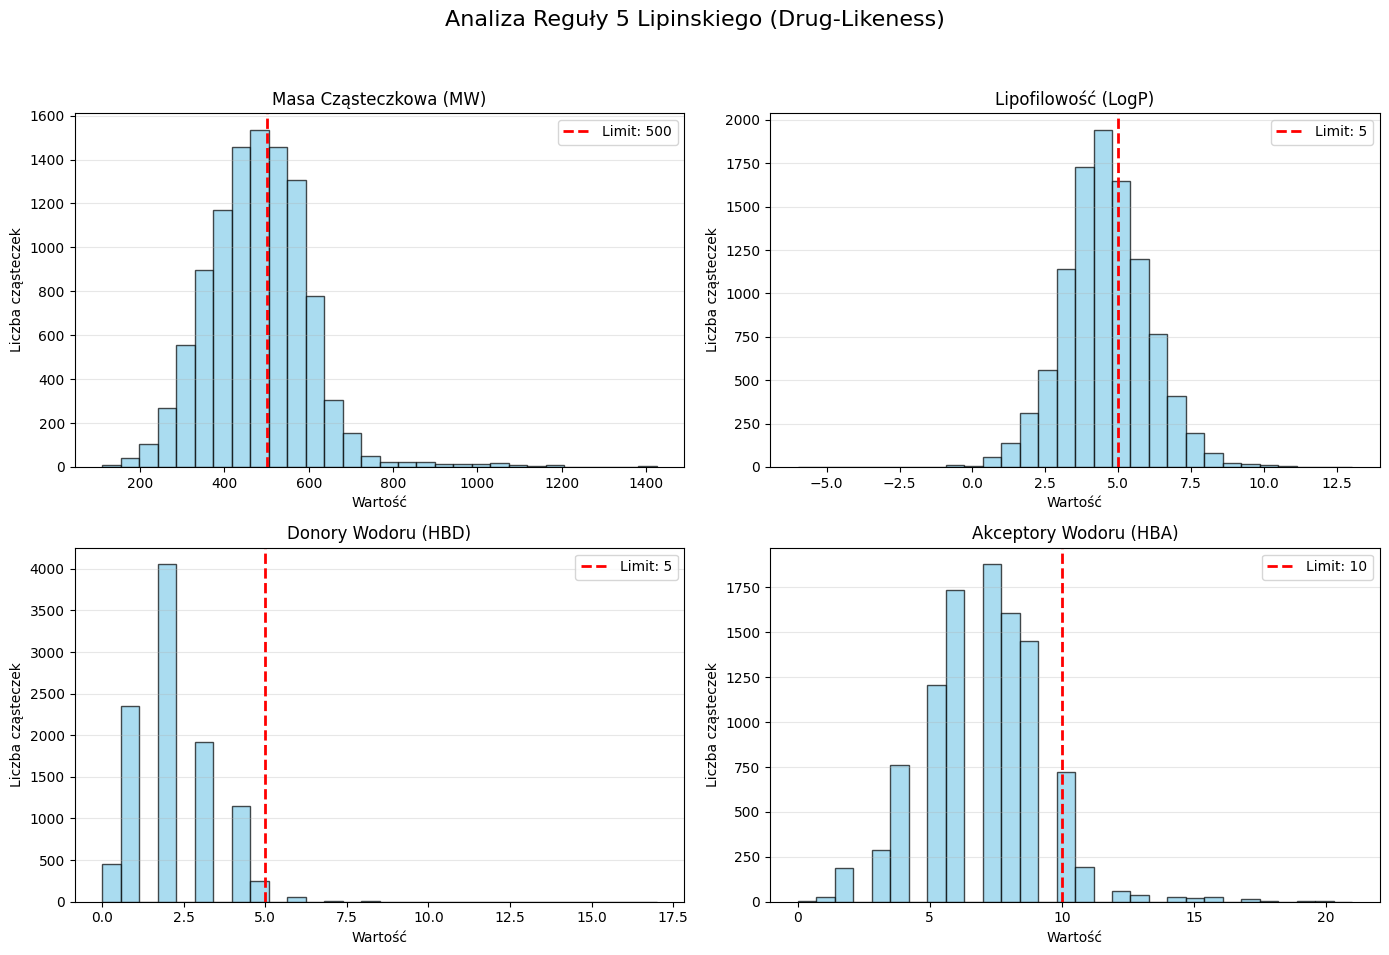

In [48]:
# Konwersja do pandas/numpy dla łatwiejszego rysowania
data_viz = df_analysis.select(["MW", "LogP", "HBD", "HBA"]).to_pandas()

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Analiza Reguły 5 Lipinskiego (Drug-Likeness)', fontsize=16)

# Parametry wykresów (Kolumna, Tytuł, Limit Lipinskiego)
params = [
    ("MW", "Masa Cząsteczkowa (MW)", 500),
    ("LogP", "Lipofilowość (LogP)", 5),
    ("HBD", "Donory Wodoru (HBD)", 5),
    ("HBA", "Akceptory Wodoru (HBA)", 10)
]

# Pętla rysująca 4 histogramy
for ax, (col, title, limit) in zip(axs.flat, params):
    ax.hist(data_viz[col], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    ax.axvline(limit, color='red', linestyle='--', linewidth=2, label=f'Limit: {limit}')
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('Wartość')
    ax.set_ylabel('Liczba cząsteczek')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()